In [4]:
from IPython.display import display, HTML

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%reload_ext jupyternotify

# %notify


import sys

import numpy as np
import qutip as qtp
import matplotlib.pyplot as plt
import cmath
from pysqkit.util.linalg import tensor_prod

import time
import datetime
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 7)

import pysqkit.tomography.utilsTomo as tomo
import pysqkit

<IPython.core.display.Javascript object>

# Description of Tomography Process

## $\{ \rho_i \}$

We take the following convention : 
$$\text{The } \left\{ \rho_i \right\} \text{ are the } \left|n\right>\left<m\right| \text{ ; } n,m \in [\![0, \text{d} ]\!]^2 $$
$$ \text{For 2 systems : the } \left\{ \left|n\right> \right\} \text{are the} \left|ab\right> \text{ ; } a,b \in [\![0, \textit{nb_levels}[0] ]\!] \times [\![0, \textit{nb_levels}[1] ]\!] $$

 
R) d is the total number of levels : $d = \prod _{i} \textit{nb_levels}[i]$ 
In the case of quBits, $d = 2^n$ with $n$ being the number of qubits in the system.  \
For quDits having k levels, it is $d = k^n$



R) There are $d^2$ terms in the $\left\{\rho_i\right\}$ family and each of them has $d^2$ components

## $\{ \tilde{E_i} \}$

We take the following convention : \
$\{\tilde{E_i} \}$ is the basis for operators. There are $d^2$ of them and each has $d^2$ components.

Usually when there are 2 levels, we take Pauli matrices and tensor product of pauli matrices. \
For higher levels we will use Generalized Gell-Mann matrices.

If $P_j ; (j=1...d)$ is the basis for a L levels qudit then ($d=L^2$) : 
$$\forall i \in [\![1, d^2 ]\!] , \exists! j,k \in [\![1, d]\!]^2 \text{ so that } \tilde{E_i} = P_j\otimes P_k$$


## $\textit{fct_to_lambda(...)}$

$$\lambda \in d^2 \times d^2 \text{ is the matrix defined by : } \mathcal{E} (\rho_j) = \sum_k \lambda_{jk} \rho_k \text{    ($\mathcal{E}$ is the gate)}$$

## $\textit{lambda_to_chi(...)}$

The $\chi$ matrix for a basis $\left\{ \tilde{E_i} \right\}$ of operators is defined by the following formula :

$$\mathcal{E}(\rho) = \sum_{mn} \chi_{mn} \tilde{E_m}\rho\tilde{E_n}^\dagger$$

Some examples of $\chi$ matrices :

For 1 qubits : X operator $$\chi_X = \begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}$$

For 2 qubits : $U_{CNOT} = I\otimes I + I\otimes X + Z\otimes I - Z\otimes Z$ donc : 
$$\chi_{CNOT} = \begin{bmatrix}
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
-1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 &  1 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0
\end{bmatrix}$$

## $\textit{lambda} \leftrightarrow \textit{chi}$  through  $ \beta$

The $\beta$ matix is defined as follows :  
$$\tilde{E_m} \rho_j \tilde{E_n}^{\dagger} = \sum_k \beta_{jk}^{mn}  \rho_k $$
$$ m,n \in \left[\!\left[1,d^2\right]\!\right]^2 \text{  and  } j,k \in \left[\!\left[1,d^2\right]\!\right]^2$$

So if follows : 
$$\beta_{jk}^{mn} = Tr \left\{ \tilde{E_m} \rho_j \tilde{E_n}^{\dagger} \rho_k^{\dagger} \right\} $$

We choose to index $\beta$ as a matrix with rows labeled $(j,k)=\mu$ and columns labeled $(m,n) = \nu$. \
$\beta \in d^4 \times d^4$

We test 8.158 to check if the $\chi$ matrix coincides qith the caculated $\beta$ and $\lambda$:

With our convention of $\mu = (j,k)$ ans $\nu = (m,n)$ , this equation is : 
$$\sum_{\nu} \beta_{\mu}^{\nu} \chi_{\nu} = \lambda_{\mu} \ ; \ \forall \mu \in [\![ 1, d^4]\!]$$

R) The left side of this equation is labelled $\textit{lambda_th_mat}$ or $\lambda_{ij}^{th}$

## $\textit{chi_to_kraus(...)}$

We use the formula 8.168 from Nielsen and Chuang : 

$$ E_i = \sqrt{d_i}\sum_j U_{ij} \tilde{E_j}$$ 

$$ \text{  with  } U \text{  such that  } \chi = UDU^\dagger \text{ ; } U \text{ unitary and } D \text{ diagonal }$$

## Fidelities $L_1$ ; $L_2$ ; $\overline{F}$

In the equations below, $\mathcal{E}$ and $\tilde{\lambda}$ are defined as follows : 

$$ \mathcal{G} = \mathcal{G}^{\text{ideal}} \circ \mathcal{E} $$


$\lambda$ is the matrix representation of $\mathcal{G}$ in the density matrix basis. And $\tilde{\lambda}$ is the matrix representation of $\mathcal{E} in tha same basis. We obtain its value by the following formula : 

$$\tilde{\lambda} = \lambda_{\text{ideal}^{-1}} \cdot \lambda$$

We have $\lambda_{\text{ideal}^{-1}}$ = $\lambda_{\text{ideal}}^{-1}$ the representation of the ideal gate. (The $\lambda_{\text{ideal}^{-1}}$ should be easier to calculate, as the representation of the inverse of the ideal gate.)

**We use the formula (2) from Wood Gambetta :  ** 

$$L_1 = L \left( \mathcal{E} \left( \dfrac{\mathbb{1}_1}{d_1} \right) \right) = 1 - Tr \left( \mathbb{1}_1 \mathcal{E} \left( \dfrac{\mathbb{1}_1}{d_1} \right) \right)  = 1 - \sum_{\chi_1} Tr\left( |\psi_i \rangle \langle \psi_i | \cdot \mathcal{E} \left(  \dfrac{\mathbb{1}_1}{d_1} \right) \right)$$
$$L_2 = 1 - L \left( \mathcal{E} \left( \dfrac{\mathbb{1}_2}{d_2} \right) \right) = Tr \left( \mathbb{1}_1 \mathcal{E} \left( \dfrac{\mathbb{1}_2}{d_2} \right) \right)  = \sum_{\chi_1} Tr\left( |\psi_i \rangle \langle \psi_i | \cdot \mathcal{E} \left(  \dfrac{\mathbb{1}_2}{d_2} \right) \right)$$

Now : 
$$\overline{F} = \dfrac{d_1 F_{pro} (\mathcal{E}) + 1 - L_1}{d_1 + 1}$$

$$\text {With :} F_{pro} (\mathcal{E}) = \dfrac{1}{d_1^2} Tr(\mathbb{1}_1 \otimes \mathbb{1}_1 \mathcal{S}_{\mathcal{E}} )\quad \text{$\mathcal{S}_{\mathcal{E}}$ is the superoperator of the $\mathcal{E}$  (ie $\lambda$} )$$

## Single qubit corrections

We now detail how to obtain the single-qubit gates in order to bring the (ideal) gate to the CZ form
$$
\mathrm{CZ} = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}
$$
The Ficheux protocol we have just simulated realizes (ideally) a unitary 
$$
U =  \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & e^{i \phi_{01}} & 0 & 0 \\
0 & 0 & e^{i \phi_{10}} & 0 \\
0 & 0 & 0 & e^{i \phi_{11}}
\end{pmatrix}
$$
where the phases satisfy the condition
$$
\phi_{11} - \phi_{01} - \phi_{10} = \pi \mod 2 \pi.
$$
Let us define a generic single-qubit phase gate
$$
P(\phi) = \begin{pmatrix}
1 & 0 \\
0 & e^{i \phi}
\end{pmatrix}.
$$
The single-qubit gates to be applied are $P(-\phi_{01})$ on the second qubit and $P(-\phi_{10})$ on the first qubit (to see it more clearly apply them sequentially). In fact, one can check that 
$$
P(-\phi_{10}) \otimes P(-\phi_{01}) U = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i (\phi_{11} - \phi_{10} - \phi_{01})}
\end{pmatrix},
$$
which given the previous condition on the phases is equal to the CZ gate.


**R)** In the code the phases are obtained from the $\lambda$ matrix (so they have to be divided by two)

# Tutorial

## Tests from U

In [39]:
#From a U matrix :

# #Set U
# U_CNOT = np.zeros((4,4))
# U_CNOT[0,0] = 1
# U_CNOT[1,1] = 1
# U_CNOT[2,3] = 1
# U_CNOT[3,2] = 1
# U_CNOT = qtp.Qobj(U_CNOT, dims = [[2,2], [2, 2]])


# U_0 = qtp.Qobj(np.zeros((4,4)), dims = [[2,2], [2,2]])

# sigmai = qtp.sigmax()
# sigmaj = qtp.sigmaz()
# U_i_j = qtp.tensor(sigmai, sigmaj)

# nb_levels = [2, 2]

# U_rand = qtp.Qobj(2*(np.random.rand(nb_levels[0]*nb_levels[1], nb_levels[0]*nb_levels[1])-.5) + \
#                   2j*(np.random.rand(nb_levels[0]*nb_levels[1], nb_levels[0]*nb_levels[1])-.5), 
#                    dims = [nb_levels, nb_levels]).unit() #qtp.qeye([2]*mult)


nb_levels = [2, 2]
d = np.prod(nb_levels)
U_id = qtp.qeye(nb_levels)

#Use the build in constructor
U_id_err = U_id + qtp.Qobj(np.random.random((d,d))*.1 , dims = U_id.dims)#add in some error


# U_test_tpcp = tomo._Pauli_gen(34, d)

U_i_id = np.eye(4)+0j
U_i_id[3,3] = (1+1j)/np.sqrt(2)

param_test = { 'U' : U_i_id}

env_U = pysqkit.tomography.TomoEnv(system = None,
                                   definition_type = "U",
                                   nb_levels = nb_levels, 
                                   param_syst = param_test, 
                                   table_states = None)

# pysqkit.tomography.tomoEnv.draw_mat(U_test_tpcp.full(), "U")

In [59]:
qtp.Qobj(U_i_id, dims = nb_levels)

Quantum object: dims = [2, 2], shape = (4, 4), type = other
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         1.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         1.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.70710678+0.70710678j]]

<IPython.core.display.Javascript object>


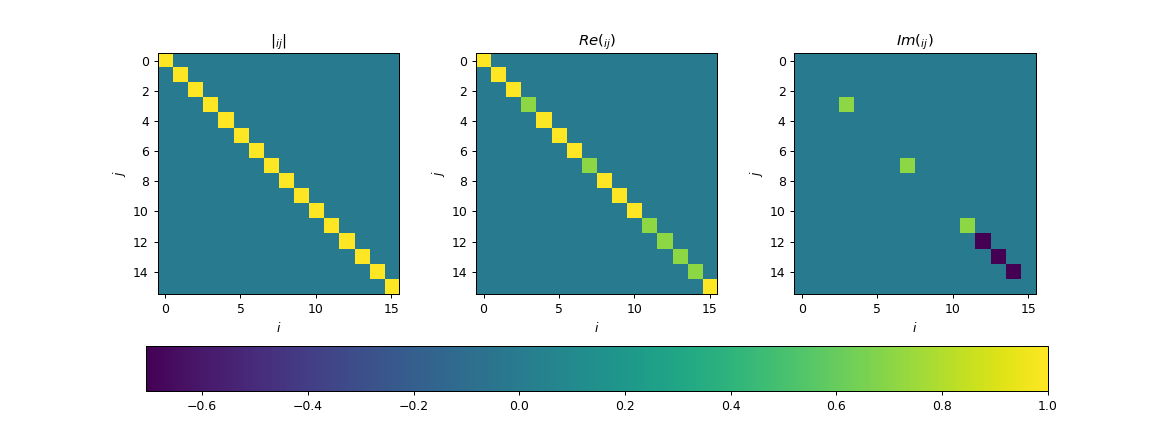

In [60]:
pysqkit.tomography.tomoEnv.draw_mat(qtp.to_super(qtp.Qobj(U_i_id, dims = [nb_levels, nb_levels])).full(), "")

## Test from Kraus

In [ ]:
#From a set of Kraus operators :

#Set list of operators

nb_levels = [3,5] #[2,2]
d = np.prod(nb_levels)

# op_list_id = [qtp.qeye(nb_levels)]

# op_list_random = [qtp.Qobj(2*(np.random.rand(d, d)-.5) + 2j*(np.random.rand(d, d)-.5), 
#                    dims = [nb_levels, nb_levels]) for i in range(d**2)]

# op_list_xyz = [qtp.tensor(qtp.qeye(2), qtp.sigmax()), 
#                qtp.tensor(qtp.qeye(2), qtp.sigmay()),
#                qtp.tensor(qtp.qeye(2), qtp.sigmaz())]

length = 100
op_list_pauli_gen = [1j * tomo._Pauli_gen(np.random.randint(d**2), d) for k in range(length)]


# Use the build in constructor
param_test = { 'op_list' : op_list_pauli_gen}

env_kraus = pysqkit.tomography.TomoEnv(system = None,
                                       definition_type = "kraus",
                                       nb_levels = nb_levels, 
                                       param_syst = param_test, 
                                       table_states = None)

In [ ]:
pysqkit.tomography.tomoEnv.draw_mat_mult([op_list_pauli_gen[k].full() for k in range(length)], ["K^"+str(k) for k in range(length)], show = True)

## Test from simu

In [ ]:
#From a simulation based process : 

# nb_levels =  
# param_test_simu = {
    
# }

# env = pysqkit.tomography.TomoEnv(nb_levels, '2-qubit simu', param_test_simu, table_states = eigstates_sys)


## Test with 'system'

In [16]:
transmon = pysqkit.qubits.SimpleTransmon(
    label='transmon', 
    max_freq = 6, 
    anharm = -0.3, 
    dim_hilbert = 3
)
fluxonium = pysqkit.qubits.Fluxonium(
    label='fluxonium',
    joseph_energy=5.900, 
    charge_energy=0.975, 
    induct_energy=0.455,
    flux = 0.5
)
fluxonium.diagonalize_basis(5)

fluxonium.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive',
    pulse_shape=None) #pysqkit.drives.pulse_shapes.gaussian_top)

system = transmon.couple_to(fluxonium, coupling=pysqkit.couplers.capacitive_coupling, strength=0.2)

times = np.linspace(0, 1, 1000)
amp = 0 #0.2
freq = 0.5

# system['fluxonium'].drives['cz_drive'].set_params(phase=0, time = times, amp = amp, freq = freq, rise_time=1)
system['fluxonium'].drives['cz_drive'].set_params(phase=0, time = times, amp = amp, freq = freq) #no pulse shape
print("Free params : ", system['fluxonium'].drives['cz_drive'].free_params)


env_syst =  pysqkit.tomography.TomoEnv(system = system)

Free params :  []


## Tomography

In [27]:
env = env_U

<IPython.core.display.Javascript object>


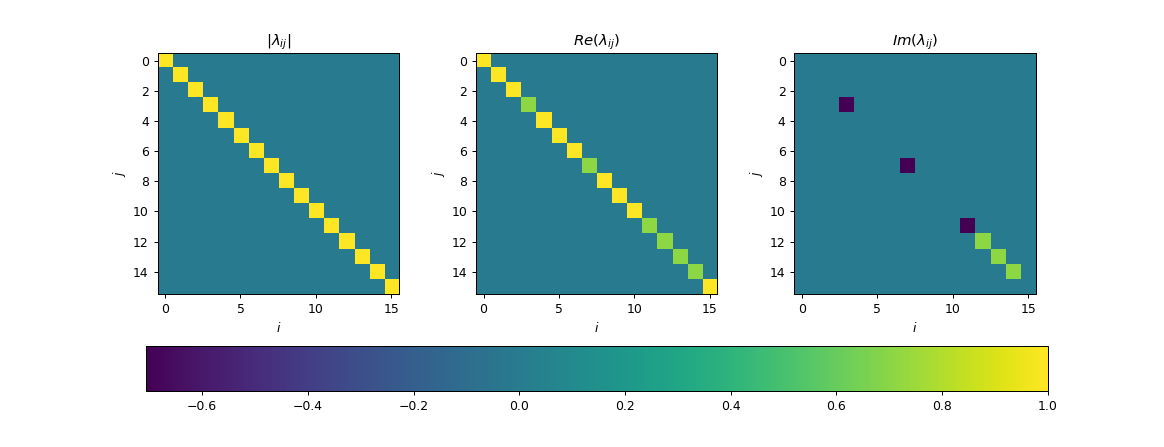

It took 0.4345688819885254 seconds


In [28]:
labels_chi_1 = [(0,0), (1,0), (0,1), (1,1)]
ind_chi_1 = [env_syst._label_to_index(label) for label in labels_chi_1]
ind_chi_2 = []
for k in range(env_syst.d):
    if not k in ind_chi_1:
        ind_chi_2.append(k)
labels_chi_2 = [env_syst._index_to_label(ind) for ind in ind_chi_2]


deb =  time.time()
lambda_mat = env.fct_to_lambda(in_labels = "comp_states", out_labels = "comp_states", 
                               draw_lambda = True, as_qobj = False)
print("It took" , time.time() - deb, "seconds")

#options for labels are "all" ; "comp_states" or a list

In [18]:
d1 = 4
d2 = env.d - 4

L1 = env.L1()
L2 = env.L2()

In [19]:
print("L1 error is ; ", L1)
print("L2 error is ; ", L2)

print("d1 x L1 = ", d1*L1, "and d2 x L2 = ", d2*L2 )

L1 error is ;  (7.743123253689532e-09-1.278325315686143e-16j)
L2 error is ;  0j
d1 x L1 =  (3.097249301475813e-08-5.113301262744572e-16j) and d2 x L2 =  0j


### Alternate L1 and L2

In [ ]:
# def correc_U(env):
    
#     #we bypass the gate implemented functions and give a ket to the system
# #     u_10_10 = (env.param_syst['simu'](env._ket_label((1,0))).dag() * env._ket_label((1,0)) ).full()
# #     u_01_01 = (env.param_syst['simu'](env._ket_label((0,1))).dag() * env._ket_label((0,1)) ).full()
# #     u_00_00 = (env.param_syst['simu'](env._ket_label((0,0))).dag() * env._ket_label((0,0)) ).full()
    
# #     phi_10 = cmath.phase(np.conj(u_00_00) * u_10_10) #u_00_00 a 1 in 00 (similar calculations)
# #     phi_01 = cmath.phase(np.conj(u_00_00) * u_01_01)
    
#     p_phi10 = np.diag(np.ones(env.nb_levels[0])) + 0j
#     p_phi01 = np.diag(np.ones(env.nb_levels[1])) + 0j
# #     p_phi10[:2, :2] = np.array([[1, 0], [0, np.exp(1j*phi_10)]])
# #     p_phi01[:2, :2] = np.array([[1, 0], [0, np.exp(1j*phi_01)]])
    
# #     print(p_phi10, phi_01)
#     return tensor_prod([p_phi10, p_phi01])

## Process fidelity

In [ ]:
# We aim here for the identity
U_id = np.eye(env.d)

In [ ]:
def correc_U(env):
    
    #we bypass the gate implemented functions and give a ket to the system
#     u_10_10 = (env.param_syst['simu'](env._ket_label((1,0))).dag() * env._ket_label((1,0)) ).full()
#     u_01_01 = (env.param_syst['simu'](env._ket_label((0,1))).dag() * env._ket_label((0,1)) ).full()
#     u_00_00 = (env.param_syst['simu'](env._ket_label((0,0))).dag() * env._ket_label((0,0)) ).full()
    
#     phi_10 = cmath.phase(np.conj(u_00_00) * u_10_10) #u_00_00 a 1 in 00 (similar calculations)
#     phi_01 = cmath.phase(np.conj(u_00_00) * u_01_01)
    
    p_phi10 = np.diag(np.ones(env.nb_levels[0])) + 0j
    p_phi01 = np.diag(np.ones(env.nb_levels[1])) + 0j
#     p_phi10[:2, :2] = np.array([[1, 0], [0, np.exp(1j*phi_10)]])
#     p_phi01[:2, :2] = np.array([[1, 0], [0, np.exp(1j*phi_01)]])
    
#     print(p_phi10, phi_01)
    return tensor_prod([p_phi10, p_phi01])

In [ ]:
from pysqkit.tomography.tomoEnv import *
pysqkit.tomography.tomoEnv.process_fidelity(env, U_id, correc_U)

In [ ]:
pysqkit.tomography.tomoEnv.avg_gate_fid(env, U_id, correc_U)

In [ ]:
#Or all from scratch : 
print("The L1 is :", pysqkit.tomography.tomoEnv.L1_from_scratch(system))
print("The Fpro is :", pysqkit.tomography.tomoEnv.process_fidelity_from_scratch(system, U_id, single_qubit_correction))
print("The F is :", pysqkit.tomography.tomoEnv.avg_gate_fid_from_scratch(system, U_id, single_qubit_correction))

# Not used

In [ ]:
# deb =  time.time()
# PTM_mat = env_U.fct_to_PTM(draw_PTM = True, as_qobj = False)
# print("It took" , time.time() - deb, "seconds")

In [ ]:
# deb =  time.time()
# chi_mat = env_U.lambda_to_chi(lambda_mat, draw_chi = True, as_qobj = False)
# print("It took" , time.time() - deb, "seconds")

In [ ]:
# deb = time.time()
# kraus_list = env_U.chi_to_kraus(chi_mat, draw_kraus = True, as_qobj = False)
# print("It took" , time.time() - deb, "seconds")

In [ ]:
# deb = time.time()
# PTM_mat_from_chi = env_U.chi_to_PTM(chi_mat, draw_PTM = True, as_qobj = True)
# print("It took" , time.time() - deb, "seconds")

In [ ]:
# #tests using beta, very costly in complexity
# deb = time.time()
# lambda_mat_from_beta = env_U.chi_to_lambda_beta(chi_mat, draw_lambda = True)
# print("It took" , time.time() - deb, "seconds")

# deb = time.time()
# chi_mat_from_beta = env_U.lambda_to_chi_beta(lambda_mat, draw_chi = True)
# print("It took" , time.time() - deb, "seconds")